In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.signal import savgol_filter, find_peaks, welch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.fft import fft, fftfreq
from scipy.stats import entropy

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical


In [67]:
df = pd.read_csv("ppgdata.csv")
print(df.shape)
df.head()

(54, 684)


,subject ID,labels,0,1,2,3,4,5,6,7,...,672,673,674,675,676,677,678,679,680,681
0,sub_1,normal,640.0,636.0,630.0,656.0,670.0,644.0,660.0,608.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sub_2,normal,656.0,640.0,648.0,622.0,628.0,644.0,648.0,698.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sub_3,normal,572.0,564.0,550.0,526.0,524.0,510.0,502.0,496.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,sub_4,normal,298.0,538.0,322.0,532.0,874.0,850.0,824.0,854.0,...,806.0,812.0,814.0,790.0,740.0,716.0,724.0,720.0,710.0,708.0
4,sub_5,normal,630.0,616.0,598.0,638.0,626.0,616.0,594.0,620.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Cleaning

In [ ]:
time_series = df.iloc[:, 2:].apply(pd.to_numeric, errors='coerce')
time_series = time_series.interpolate(axis=1) #interpolating missing values 

filtered_ts = savgol_filter(time_series.values, window_length = 5, polyorder = 3, axis = 1)
filtered_df_numeric = pd.DataFrame(filtered_ts, columns=time_series.columns, index=time_series.index)

clean_df = df.copy()
clean_df.iloc[:, 2:] = filtered_df_numeric.values

print(clean_df.shape)
clean_df.head()

clean_df = df.copy()
clean_df.iloc[:, 2:] = filtered_df_numeric.values

clean_df.shape
clean_df.head()

### Data Visualization

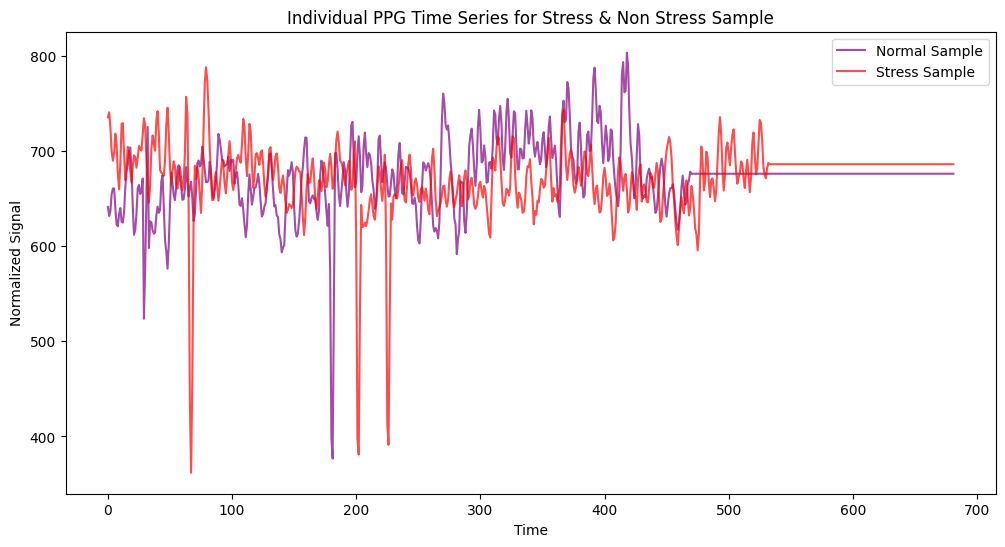

In [41]:
plt.figure(figsize=(12,6))

normal = clean_df[clean_df['labels'] == 'normal'].iloc[0, 2:]
stress = clean_df[clean_df['labels'] == 'stress'].iloc[0, 2:]

plt.plot(normal.values, label='Normal Sample', alpha=0.7, color='purple')
plt.plot(stress.values, label='Stress Sample', alpha=0.7, color='red')

plt.title("Individual PPG Time Series for Stress & Non Stress Sample")
plt.xlabel("Time")
plt.ylabel("Normalized Signal")
plt.legend()
plt.show()

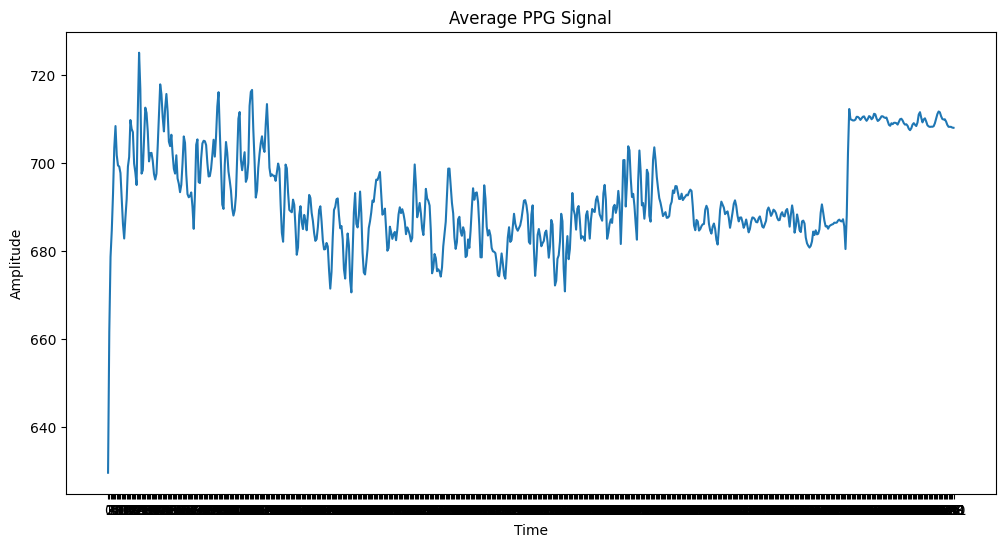

In [53]:
mean_ppg = clean_df[clean_df.columns[2:]].mean(axis=0)
plt.figure(figsize=(12,6))
plt.plot(mean_ppg)

plt.title("Average PPG Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [62]:
def get_rr_intervals(ppg_signal, fs=4):
    peaks, _ = find_peaks(ppg_signal, distance=fs*0.4)
    rr_intervals = np.diff(peaks) / fs  
    return rr_intervals

def compute_hrv(ppg_signal):
    rr = get_rr_intervals(ppg_signal)
    if len(rr) < 2: return pd.Series({col: np.nan for col in ['Mean_RR','SDNN','RMSSD','Min_RR','Max_RR','RR_Range']})
    diff_rr = np.diff(rr)

    return pd.Series({
        'Mean_RR': rr.mean(),
        'SDNN': rr.std(ddof=1),
        'RMSSD': np.sqrt(np.mean(diff_rr ** 2)),
        'Min_RR': rr.min(),
        'Max_RR': rr.max(),
        'RR_Range': rr.max() - rr.min()
    })

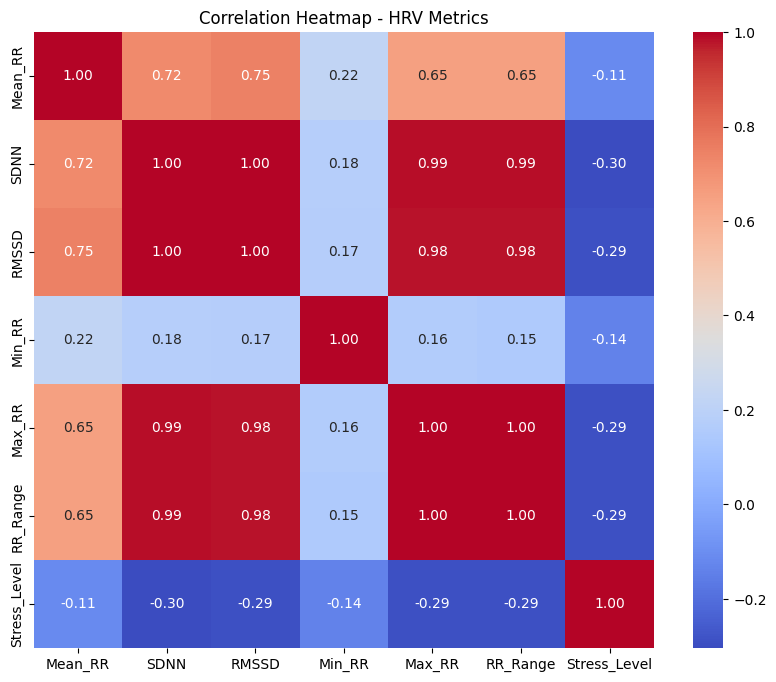

In [64]:
focus_cols = clean_df.columns[2:]

hrv_metrics = clean_df[focus_cols].apply(compute_hrv, axis=1)
hrv_metrics['Label'] = clean_df['labels']
hrv_metrics['Stress_Level'] = hrv_metrics['Label'].map({'normal': 0, 'stress': 1})
corr = hrv_metrics.drop(columns=['Label']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap - HRV Metrics")
plt.show()

In [76]:
focus_cols = clean_df.columns[2:]

X = clean_df[focus_cols].values
y = clean_df['labels'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame({'PC1': X_pca[:, 0], 'PC2': X_pca[:, 1], 'label': y})

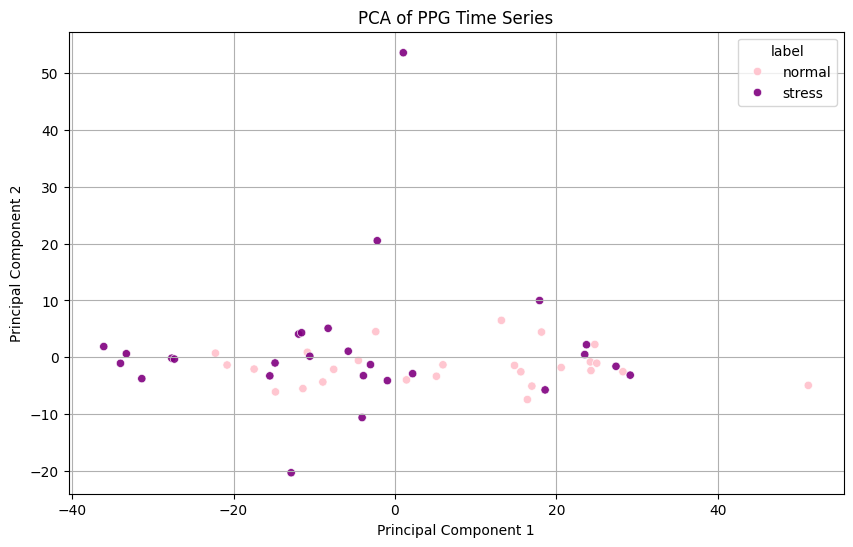

In [86]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='label', palette={'normal': 'pink', 'stress': 'purple'}, alpha=0.9)

plt.title("PCA of PPG Time Series")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

## Feature Engineering 

### Time Domain Features

In [97]:
ts_df = clean_df.iloc[:, 2:].apply(pd.to_numeric)

features = pd.DataFrame({
    'mean': ts_df.mean(axis=1),
    'min': ts_df.min(axis=1),
    'max': ts_df.max(axis=1),
    'median': ts_df.median(axis=1),
    'std': ts_df.std(axis=1),
    'variance': ts_df.var(axis=1),
    'skew': ts_df.skew(axis=1),
    'kurtosis': ts_df.kurt(axis=1),
    'range': ts_df.max(axis=1) - ts_df.min(axis=1)
})

ts_feats = pd.concat([clean_df[['subject ID', 'labels']], features], axis=1)
print(ts_feats.head())

  subject ID  labels        mean         min         max      median  \
0      sub_1  normal  673.697319  376.742857  803.085714  676.000000   
1      sub_2  normal  654.519564  595.257143  794.971429  648.028571   
2      sub_3  normal  566.453372  431.085714  859.657143  548.000000   
3      sub_4  normal  781.748303  314.800000  907.771429  786.257143   
4      sub_5  normal  612.299036  538.171429  958.914286  600.028571   

         std     variance      skew   kurtosis       range  
0  36.195955  1310.147186 -1.319913  12.219732  426.342857  
1  40.254238  1620.403710  0.925563   0.201909  199.714286  
2  49.175933  2418.272356  1.827173   5.545591  428.571429  
3  52.285799  2733.804776 -2.107318  13.726756  592.971429  
4  33.764778  1140.060247  3.140588  21.370579  420.742857  


### Frequency Domain Features (FFT)

In [102]:
def fft_feats(signal):
    fs = 4
    signal = np.nan_to_num(signal) # treat null values
    length = min(256, len(signal))

    freqs, psd = welch(signal, fs, nperseg=length)
    total_energy = np.sum(psd)
    psd_normalized = psd / total_energy if total_energy > 0 else psd
    spectral_entropy = entropy(psd_normalized)

    vlf_power = np.sum(psd[np.logical_and(freqs>=0.0, freqs<0.04)])
    lf_power = np.sum(psd[np.logical_and(freqs>=0.04, freqs<0.15)])
    hf_power = np.sum(psd[np.logical_and(freqs>=0.15, freqs<=0.40)])

    if hf_power > 0:
        lf_hf_ratio = lf_power / hf_power
    else:
        lf_hf_ratio = 0

    dom_freq = freqs[np.argmax(psd)]

    return {
        "fft_total_energy": total_energy,
        "fft_entropy": spectral_entropy,
        "fft_vlf": vlf_power,
        "fft_lf": lf_power,
        "fft_hf": hf_power,
        "fft_lf_hf_ratio": lf_hf_ratio,
        "fft_dom_freq": dom_freq,
    }

In [104]:
freq_feats_list = []
for i, row in ts_df.iterrows():
    feats = fft_feats(row.values)
    feats['subject ID'] = clean_df.loc[i, 'subject ID']
    freq_feats_list.append(feats)

freqdomain_feats = pd.DataFrame(freq_feats_list)
print(freqdomain_feats.head())

   fft_total_energy  fft_entropy       fft_vlf        fft_lf        fft_hf  \
0      78025.807278     3.829742  12042.188539  12588.717441  32763.028238   
1      69177.071026     3.532235   6423.631633  10392.777011  40556.019199   
2     161798.381592     3.574173  50359.643257  23671.713123  34142.443923   
3     102162.368195     3.007036  40807.544615  33576.163745  21943.970380   
4      81051.183375     3.838482   6053.334227  23046.033004  31718.192098   

   fft_lf_hf_ratio  fft_dom_freq subject ID  
0         0.384235      0.015625      sub_1  
1         0.256257      0.281250      sub_2  
2         0.693322      0.015625      sub_3  
3         1.530086      0.015625      sub_4  
4         0.726587      0.046875      sub_5  


### Data Preprocessing

In [105]:
combined_features = pd.merge(ts_feats, freqdomain_feats, on='subject ID', how='inner')
combined_features.dropna(inplace=True)
X = combined_features.drop(columns=['subject ID', 'labels'])
y = combined_features['labels']

# Check if there are any null or missing data values
print(X.isnull())
# Treat if necessary
X = X.fillna(0)
print(X.isnull())

# Use StandardScaler to scale the data values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Using an 80-20 split for training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42, stratify=y)

print("Combined Features head:")
print(combined_features.head())
print("\n")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

      mean    min    max  median    std  variance   skew  kurtosis  range  \
0    False  False  False   False  False     False  False     False  False   
1    False  False  False   False  False     False  False     False  False   
2    False  False  False   False  False     False  False     False  False   
3    False  False  False   False  False     False  False     False  False   
4    False  False  False   False  False     False  False     False  False   
..     ...    ...    ...     ...    ...       ...    ...       ...    ...   
103  False  False  False   False  False     False  False     False  False   
104  False  False  False   False  False     False  False     False  False   
105  False  False  False   False  False     False  False     False  False   
106  False  False  False   False  False     False  False     False  False   
107  False  False  False   False  False     False  False     False  False   

     fft_total_energy  fft_entropy  fft_vlf  fft_lf  fft_hf  fft_lf_hf_rati

## Model Training

In [109]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 172.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 121.4 MB/s eta 0:00:0000:0100:01


In [121]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [125]:
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test_enc, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

Random Forest Accuracy: 0.8181818181818182
              precision    recall  f1-score   support

      normal       0.73      1.00      0.85        11
      stress       1.00      0.64      0.78        11

    accuracy                           0.82        22
   macro avg       0.87      0.82      0.81        22
weighted avg       0.87      0.82      0.81        22



In [127]:
svm = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test_enc, y_pred_svm))
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

SVM Accuracy: 0.5454545454545454
              precision    recall  f1-score   support

      normal       0.53      0.73      0.62        11
      stress       0.57      0.36      0.44        11

    accuracy                           0.55        22
   macro avg       0.55      0.55      0.53        22
weighted avg       0.55      0.55      0.53        22



In [140]:
xgb = XGBClassifier(n_estimators=300, learning_rate=0.001, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))

XGBoost Accuracy: 0.9090909090909091
              precision    recall  f1-score   support

      normal       0.85      1.00      0.92        11
      stress       1.00      0.82      0.90        11

    accuracy                           0.91        22
   macro avg       0.92      0.91      0.91        22
weighted avg       0.92      0.91      0.91        22



## Model Evaluation

SVM Model
SVM Accuracy: 0.5455
SVM Confusion Matrix:


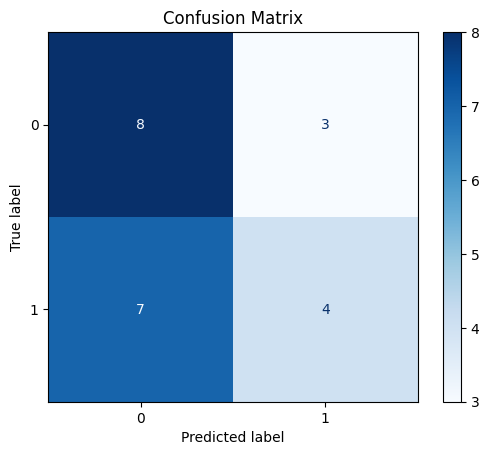


Random Forest Model
RF Accuracy: 0.8182
RF Confusion Matrix:


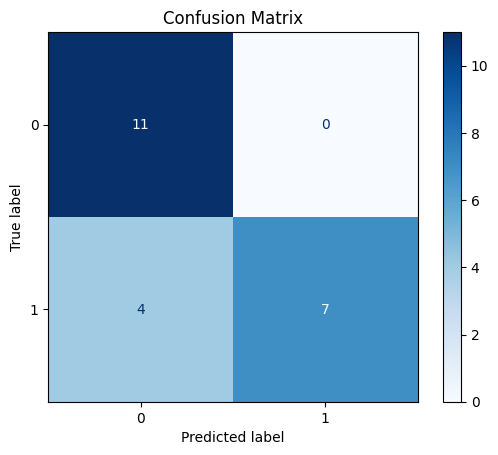

XGBoost Model
XGBoost Accuracy: 0.9091
XGBoost Confusion Matrix:


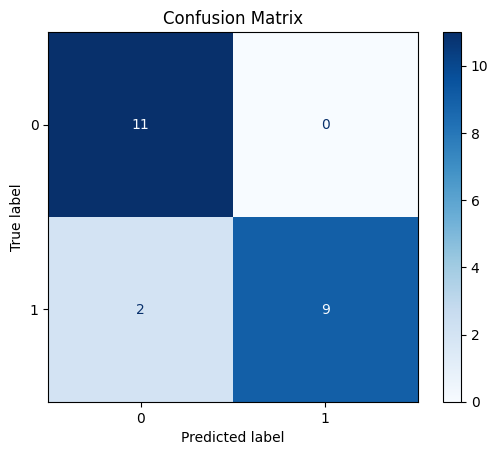

In [132]:
print("SVM Model")
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print("SVM Confusion Matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_svm), display_labels=rf_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print("\nRandom Forest Model")
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"RF Accuracy: {rf_accuracy:.4f}")
print("RF Confusion Matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_rf), display_labels=rf_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print("XGBoost Model")
svm_accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {svm_accuracy:.4f}")
print("XGBoost Confusion Matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_xgb), display_labels=rf_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [141]:
rf = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}

rf_grid_search = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    cv=3, 
    scoring='roc_auc',
    n_jobs=-1, 
    verbose=1
)

rf_grid_search.fit(X_train, y_train)

print("Best RF parameters:", rf_grid_search.best_params_)
print("Best RF ROC_AUC:", rf_grid_search.best_score_)

# Use test set
y_pred_rf = rf_grid_search.best_estimator_.predict(X_test)
print("RF Test Accuracy:", accuracy_score(y_test, y_pred_rf))

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best RF parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}
Best RF ROC_AUC: 0.740702947845805
RF Test Accuracy: 0.7727272727272727


In [139]:
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
}

xgb_gs = GridSearchCV(
    estimator=xgb,
    param_grid=xgb_param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

xgb_gs.fit(X_train, y_train_enc)

print("Best XGB parameters:", xgb_gs.best_params_)
print("Best XGB ROC_AUC:", xgb_gs.best_score_)

# Use test set
y_pred_xgb = xgb_gs.best_estimator_.predict(X_test)
print("XGB Test Accuracy:", accuracy_score(y_test, y_pred_xgb))

Best XGB parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Best XGB ROC_AUC: 0.8115646258503402
XGB Test Accuracy: 0.8181818181818182
